Run scraper
<br>
Create fighter_bouts_joined table from scraped_data.db using <project_root>/SQL/fighter_botus_join_query.sql
<br>
clean data

Questions:
- is harder to predict fights as rankings increase?

SLpM - Significant Strikes Landed per Minute

Str. Acc. - Significant Striking Accuracy

SApM - Significant Strikes Absorbed per Minute

Str. Def. - Significant Strike Defence (the % of opponents strikes that did not land)

TD Avg. - Average Takedowns Landed per 15 minutes

TD Acc. - Takedown Accuracy

TD Def. - Takedown Defense (the % of opponents TD attempts that did not land)

Sub. Avg. - Average Submissions Attempted per 15 minutes

In [89]:
import os, sys
from pathlib import Path
import pandas as pd
import sqlite3
import processor
import numpy as np

sys.path.insert(0, os.path.abspath('/home/justin/pycharmprojects/fight_predictor/predictor/'))
# pd.options.display.float_format = '{:,.2f}'.format

In [90]:
# project_root = Path("/home/justin/projects/fight_predictor")
project_root = Path("/home/justin/pycharmprojects/fight_predictor")
data_dir = project_root / "predictor" / "Data" / "Scraped_Data"
scrapers_dir = project_root / "predictor" / "scrapers"
# fighters = pd.read_csv(data_dir / "scraped_fighters.csv")

In [95]:
# dbpath = scrapers_dir / 'db' / 'scraped_data.db'
dbpath = scrapers_dir  / 'db' / 'scraped_data.db.bak5'
print(dbpath)
# /home/justin/pycharmprojects/fight_predictor/predictor/scrapers/db/scraped_data.db

/home/justin/pycharmprojects/fight_predictor/predictor/scrapers/db/scraped_data.db.bak5


In [96]:
cnx = sqlite3.connect(dbpath)

Run if fighter_bouts_join table doesn't exist

In [97]:
# with (project_root / "SQL" / "fighter_bouts_join_query.sql").open() as sql_file:
#     sql_script = sql_file.read()
#     cnx.cursor().executescript(sql_script)
#     cnx.commit()
#     cnx.close()


#fbjdb.to_csv(data_dir / "fighter_bouts_joined.csv")

In [98]:
fdf = pd.read_sql_query("SELECT * FROM fighters", cnx)
bdf = pd.read_sql_query("SELECT * FROM bouts", cnx)
# fbdf = pd.read_sql_query("SELECT * FROM fighter_bouts_joined", cnx)

In [99]:
bdf.head(20)

,event_date,event_name,fighter1,fighter2,pass_stat_f1,pass_stat_f2,round_,str_stat_f1,str_stat_f2,sub_stat_f1,sub_stat_f2,td_stat_f1,td_stat_f2,time,weight_class,win_method_finish,win_method_type,winner
0,January 21 2023,UFC 283: Teixeira vs. Hill,Jamahal Hill,Glover Teixeira,0,0,5,0,0,0,2,232,75,5.00,Light Heavyweight,,U-DEC,Jamahal Hill
1,January 21 2023,UFC 283: Teixeira vs. Hill,Brandon Moreno,Deiveson Figueiredo,0,2,3,0,0,3,1,48,19,5.00,Flyweight,,KO/TKO,Brandon Moreno
2,January 21 2023,UFC 283: Teixeira vs. Hill,Gilbert Burns,Neil Magny,1,0,1,0,0,1,0,5,4,4.15,Welterweight,Arm Triangle,SUB,Gilbert Burns
3,January 21 2023,UFC 283: Teixeira vs. Hill,Jessica Andrade,Lauren Murphy,0,0,3,0,0,1,0,231,100,5.00,Women's Flyweight,,U-DEC,Jessica Andrade
4,January 21 2023,UFC 283: Teixeira vs. Hill,Johnny Walker,Paul Craig,0,0,1,1,0,0,0,16,3,2.16,Light Heavyweight,Punches,KO/TKO,Johnny Walker
5,January 21 2023,UFC 283: Teixeira vs. Hill,Ihor Potieria,Mauricio Rua,0,0,1,1,0,0,0,21,17,4.05,Light Heavyweight,Punches,KO/TKO,Ihor Potieria
6,January 21 2023,UFC 283: Teixeira vs. Hill,Brunno Ferreira,Gregory Rodrigues,0,0,1,1,0,0,0,22,21,4.13,Middleweight,Punch,KO/TKO,Brunno Ferreira
7,January 21 2023,UFC 283: Teixeira vs. Hill,Thiago Moises,Melquizael Costa,1,0,2,0,0,4,0,22,23,4.05,Lightweight,Rear Naked Choke,SUB,Thiago Moises
8,January 21 2023,UFC 283: Teixeira vs. Hill,Gabriel Bonfim,Mounir Lazzez,1,0,1,0,0,0,0,9,9,0.49,Welterweight,Guillotine Choke,SUB,Gabriel Bonfim
9,January 21 2023,UFC 283: Teixeira vs. Hill,Jailton Almeida,Shamil Abdurakhimov,0,0,2,0,0,3,0,45,1,2.56,Heavyweight,Punches,KO/TKO,Jailton Almeida


In [115]:
bdf.describe()

,pass_stat_f1,pass_stat_f2,round_,str_stat_f1,str_stat_f2,sub_stat_f1,sub_stat_f2,td_stat_f1,td_stat_f2,time
count,6940.000000,6940.000000,6940.000000,6940.00000,6940.000000,6940.000000,6940.000000,6940.000000,6940.000000,6940.000000
mean,0.539914,0.254755,2.334438,0.36830,0.064121,1.456484,0.669741,42.472478,28.042219,3.670336
std,0.949355,0.696852,1.013724,0.61031,0.269095,1.983789,1.192705,34.002869,26.527802,1.709661
min,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000
25%,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,17.000000,7.000000,2.290000
50%,0.000000,0.000000,3.000000,0.00000,0.000000,1.000000,0.000000,35.000000,21.000000,4.470000
75%,1.000000,0.000000,3.000000,1.00000,0.000000,2.000000,1.000000,60.000000,41.000000,5.000000
max,10.000000,7.000000,5.000000,5.00000,3.000000,21.000000,11.000000,445.000000,271.000000,18.000000


In [101]:
pd.Series(bdf.columns)

0            event_date
1            event_name
2              fighter1
3              fighter2
4          pass_stat_f1
5          pass_stat_f2
6                round_
7           str_stat_f1
8           str_stat_f2
9           sub_stat_f1
10          sub_stat_f2
11           td_stat_f1
12           td_stat_f2
13                 time
14         weight_class
15    win_method_finish
16      win_method_type
17               winner
dtype: object

In [103]:
# bdf.isnull().sum()

print(bdf[bdf["pass_stat_f1"] == 0]["pass_stat_f1"].count())
print(bdf[bdf["pass_stat_f2"] == 0]["pass_stat_f2"].count())
print(bdf[bdf["pass_stat_f1"] == 0]["pass_stat_f1"].count())
print(bdf[bdf["pass_stat_f2"] == 0]["pass_stat_f2"].count())
print(bdf[bdf["str_stat_f1"] == 0]["str_stat_f1"].count())
print(bdf[bdf["str_stat_f2"] == 0]["str_stat_f2"].count())
print(bdf[bdf["sub_stat_f1"] == 0]["sub_stat_f1"].count())
print(bdf[bdf["sub_stat_f2"] == 0]["sub_stat_f2"].count())
print(bdf[bdf["td_stat_f1"] == 0]["td_stat_f2"].count())
print(bdf[bdf["td_stat_f2"] == 0]["td_stat_f2"].count())
print(bdf[bdf["time"] == 0]["time"].count())


4571
5829
4571
5829
4786
6536
3049
4454
67
263
0


In [104]:
name = "Anderson Silva"
bdf[(bdf.fighter1 == name) | (bdf.fighter2 == name)]

,event_date,event_name,fighter1,fighter2,pass_stat_f1,pass_stat_f2,round_,str_stat_f1,str_stat_f2,sub_stat_f1,sub_stat_f2,td_stat_f1,td_stat_f2,time,weight_class,win_method_finish,win_method_type,winner
753,June 28 2006,UFC Fight Night 5,Anderson Silva,Chris Leben,0,0,1,2,0,0,0,17,1,0.49,Middleweight,Punches,KO/TKO,Anderson Silva
806,October 14 2006,UFC 64: Unstoppable,Anderson Silva,Rich Franklin,0,0,1,1,0,0,0,31,10,2.59,Middleweight,Knees,KO/TKO,Anderson Silva
857,February 03 2007,UFC 67: All or Nothing,Anderson Silva,Travis Lutter,2,0,2,0,0,0,3,9,8,2.11,Middleweight,Triangle Choke,SUB,Anderson Silva
939,July 07 2007,UFC 73: Stacked,Anderson Silva,Nate Marquardt,0,0,1,1,0,1,1,10,3,4.50,Middleweight,Punches,KO/TKO,Anderson Silva
983,October 20 2007,UFC 77: Hostile Territory,Anderson Silva,Rich Franklin,0,0,2,3,0,0,1,39,22,1.07,Middleweight,Knees,KO/TKO,Anderson Silva
1047,March 01 2008,UFC 82: Pride of a Champion,Anderson Silva,Dan Henderson,1,0,2,0,0,0,1,47,20,4.52,Middleweight,Rear Naked Choke,SUB,Anderson Silva
1121,July 19 2008,UFC: Silva vs Irvin,Anderson Silva,James Irvin,0,0,1,1,0,0,0,13,0,1.01,Light Heavyweight,Punch,KO/TKO,Anderson Silva
1172,October 25 2008,UFC 90: Silva vs Cote,Anderson Silva,Patrick Cote,0,0,3,0,0,1,0,29,16,0.39,Middleweight,,KO/TKO,Anderson Silva
1282,April 18 2009,UFC 97: Redemption,Anderson Silva,Thales Leites,0,0,5,0,0,0,1,94,10,5.00,Middleweight,,U-DEC,Anderson Silva
1339,August 08 2009,UFC 101: Declaration,Anderson Silva,Forrest Griffin,0,0,1,3,0,0,0,13,3,3.23,Light Heavyweight,Punch,KO/TKO,Anderson Silva


### Fighter DF

In [117]:
fdf.describe()

,height,reach,sapm,slpm,strike_acc,strike_def,sub_avg,td_acc,td_avg,td_def,weight,no_contest,win,loss,draw,total_fights,win_loss_ratio
count,3650.000000,1999.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3644.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3648.000
mean,70.214795,71.667334,3.215589,2.510474,37.231507,44.796986,0.661068,27.846575,1.304510,41.173973,171.601262,0.140000,12.972329,5.946575,0.271233,19.330137,inf
std,3.499113,4.225250,2.734854,1.895122,19.314942,20.925206,1.614805,28.901862,1.943513,33.938172,40.280759,0.397808,9.491428,5.110631,0.776731,13.653135,NaN
min,60.000000,58.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
25%,68.000000,69.000000,1.800000,1.102500,31.000000,39.000000,0.000000,0.000000,0.000000,0.000000,145.000000,0.000000,7.000000,3.000000,0.000000,11.000000,1.583
50%,70.000000,72.000000,2.970000,2.430000,41.000000,51.000000,0.000000,25.000000,0.700000,47.000000,170.000000,0.000000,11.000000,5.000000,0.000000,17.000000,2.333
75%,73.000000,75.000000,4.190000,3.600000,49.000000,58.000000,0.800000,46.000000,2.000000,67.000000,185.000000,0.000000,17.000000,8.000000,0.000000,25.000000,3.500
max,89.000000,84.000000,52.500000,22.110000,100.000000,100.000000,23.700000,100.000000,32.140000,100.000000,770.000000,4.000000,253.000000,83.000000,9.000000,308.000000,inf


In [105]:
replacedash = lambda x: np.nan if x == "--" else x
fdf["dob"] = fdf["date_of_birth"].apply(replacedash)
fdf["dob"] = pd.to_datetime(fdf["dob"])
fdf.head(20)

,date_of_birth,fighter_name,fighter_record,height,reach,sapm,slpm,stance,strike_acc,strike_def,sub_avg,td_acc,td_avg,td_def,weight,dob
0,Mar 02 1992,Hunter Azure,Record: 9-2-0,"5' 8""",69.0,2.08,3.92,Orthodox,53,58,1.3,34,1.97,67,145.0,1992-03-02
1,Jul 17 1990,Michael Byrnes,Record: 5-3-0,"5' 11""",NaN,0.00,0.00,,0,0,0.0,0,0.00,0,155.0,1990-07-17
2,Feb 07 1989,Gleidson Cutis,Record: 7-4-0,"5' 9""",NaN,8.28,2.99,Orthodox,52,59,0.0,0,0.00,0,155.0,1989-02-07
3,Aug 11 1990,Rolando Dy,Record: 9-7-1 (1 NC),"5' 8""",69.0,4.47,3.04,Orthodox,37,52,0.0,20,0.30,68,145.0,1990-08-11
4,Jul 27 1986,Jessica Eye,Record: 15-11-0 (1 NC),"5' 6""",66.0,4.19,3.86,Orthodox,37,55,0.5,40,0.58,57,125.0,1986-07-27
5,Nov 10 1980,Katsuaki Furuki,Record: 1-1-0,"6' 0""",NaN,2.67,0.27,,10,39,3.0,0,0.00,0,168.0,1980-11-10
6,Sep 17 1974,Mike Guymon,Record: 15-6-1,"6' 0""",74.0,0.79,2.75,Orthodox,65,66,1.2,37,1.87,54,170.0,1974-09-17
7,Sep 02 1988,Young Hwang,Record: 8-5-0,"5' 9""",NaN,0.00,0.00,,0,0,0.0,0,0.00,0,135.0,1988-09-02
8,Jun 22 1982,Hiroshi Izumi,Record: 4-2-0,--,NaN,2.65,1.95,Orthodox,37,66,0.5,70,3.35,100,205.0,1982-06-22
9,Jul 09 1985,Cristiane Justino,Record: 21-2-0 (1 NC),"5' 8""",68.0,2.25,7.28,Orthodox,52,64,0.4,55,0.66,94,145.0,1985-07-09


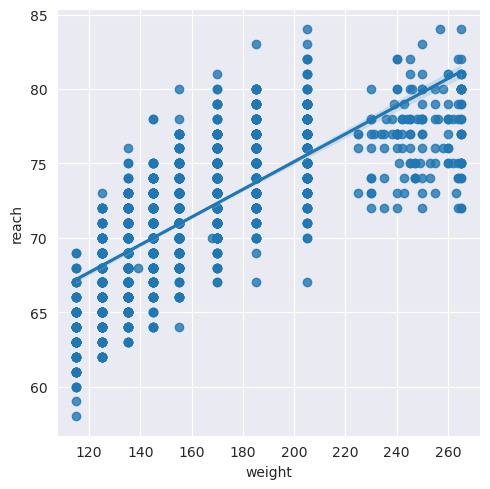

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

tempdf = fdf[["weight", "reach"]].dropna()
sns.lmplot(data=tempdf, x="weight", y="reach")
plt.show()

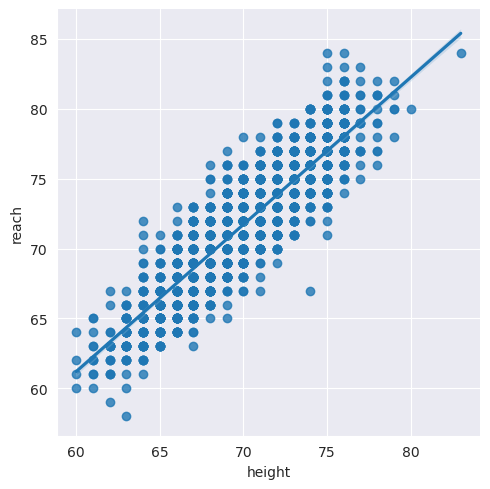

In [107]:
def parse_fighter_height(height):
    if height:
        if '"' in height:
            height = height.replace('"', '')
        ht = height.split("' ")
        ft = float(ht[0])
        inch = float(ht[1])

        return (12 * ft) + inch
    else:
        pass


fdf = fdf[fdf["height"] != "--"]
fdf["height"] = fdf["height"].apply(lambda x: parse_fighter_height(x))
tempdf = fdf[["height", "reach"]].dropna()
sns.lmplot(data=tempdf, x="height", y="reach")
plt.show()

In [108]:
# import re
# # s = "Record: 19-7-1 (1 NC)"
# s2 = "Record: 9-7-1"
# s3 = "Record: 90-7-1"
# s4 = "Record: 19-7-1"
# s5 = "Record: 534-7-1"
# # val = re.search('\(([^)]+)', s2)
#
# # sp = s2.split("-")
# # sp = s3.split("-")
# # sp = s4.split("-")
# sp = s5.split("-")
# print(sp)
# match = re.search('[0-9]+', sp[0])
# print(match)
# i = match.start()
# j = match.end()
# print(i, j)
# print(sp[0][i:j])

In [127]:
import re


def parse_nocontest(x):
    if "NC" in x:
        nc_record = re.search('\(([^)]+)', x).group(1)[0]
        return int(nc_record)
    return 0


def parse_record(x):
    sp = x.split("-")
    match = re.search('[0-9]+', sp[0])
    win = int(sp[0][match.start():match.end()])
    loss, draw = int(sp[1]), int(sp[2][0])
    ratio = win/loss if win != 0 and loss != 0 else 0
    return pd.Series([win, loss, draw, ratio])


fdf["no_contest"] = fdf.fighter_record.apply(parse_nocontest)
fdf[["win", "loss", "draw", "win_loss_ratio"]] = fdf.fighter_record.apply(parse_record)
fdf["total_fights"] = fdf["win"] + fdf["loss"] + fdf["draw"] + fdf["no_contest"]
# fdf["win_loss_ratio"] = (fdf["win"] / fdf["loss"]).round(3)
fdf

,date_of_birth,fighter_name,fighter_record,height,reach,sapm,slpm,stance,strike_acc,strike_def,...,td_avg,td_def,weight,dob,no_contest,win,loss,draw,total_fights,win_loss_ratio
0,Mar 02 1992,Hunter Azure,Record: 9-2-0,68.0,69.0,2.08,3.92,Orthodox,53,58,...,1.97,67,145.0,1992-03-02,0,9.0,2.0,0.0,11.0,4.500000
1,Jul 17 1990,Michael Byrnes,Record: 5-3-0,71.0,NaN,0.00,0.00,,0,0,...,0.00,0,155.0,1990-07-17,0,5.0,3.0,0.0,8.0,1.666667
2,Feb 07 1989,Gleidson Cutis,Record: 7-4-0,69.0,NaN,8.28,2.99,Orthodox,52,59,...,0.00,0,155.0,1989-02-07,0,7.0,4.0,0.0,11.0,1.750000
3,Aug 11 1990,Rolando Dy,Record: 9-7-1 (1 NC),68.0,69.0,4.47,3.04,Orthodox,37,52,...,0.30,68,145.0,1990-08-11,1,9.0,7.0,1.0,18.0,1.285714
4,Jul 27 1986,Jessica Eye,Record: 15-11-0 (1 NC),66.0,66.0,4.19,3.86,Orthodox,37,55,...,0.58,57,125.0,1986-07-27,1,15.0,11.0,0.0,27.0,1.363636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3917,Jun 29 1983,Ricky Rainey,Record: 12-6-0,73.0,77.0,2.62,2.55,Switch,48,46,...,0.95,55,170.0,1983-06-29,0,12.0,6.0,0.0,18.0,2.000000
3918,Dec 07 1974,Amir Rahnavardi,Record: 11-10-0,72.0,NaN,0.00,0.67,Orthodox,25,100,...,0.00,50,205.0,1974-12-07,0,11.0,10.0,0.0,21.0,1.100000
3919,Jan 06 1981,Josh Rafferty,Record: 9-8-0,72.0,NaN,3.60,0.60,Orthodox,33,50,...,0.00,0,170.0,1981-01-06,0,9.0,8.0,0.0,17.0,1.125000
3920,--,Gilbert Rael,Record: 1-3-0,68.0,NaN,7.46,0.00,,0,37,...,4.86,0,155.0,NaT,0,1.0,3.0,0.0,4.0,0.333333


In [129]:
fdf.columns

Index(['date_of_birth', 'fighter_name', 'fighter_record', 'height', 'reach',
       'sapm', 'slpm', 'stance', 'strike_acc', 'strike_def', 'sub_avg',
       'td_acc', 'td_avg', 'td_def', 'weight', 'dob', 'no_contest', 'win',
       'loss', 'draw', 'total_fights', 'win_loss_ratio'],
      dtype='object')

/tmp/ipykernel_6832/2797376688.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(corcolsdf.corr())


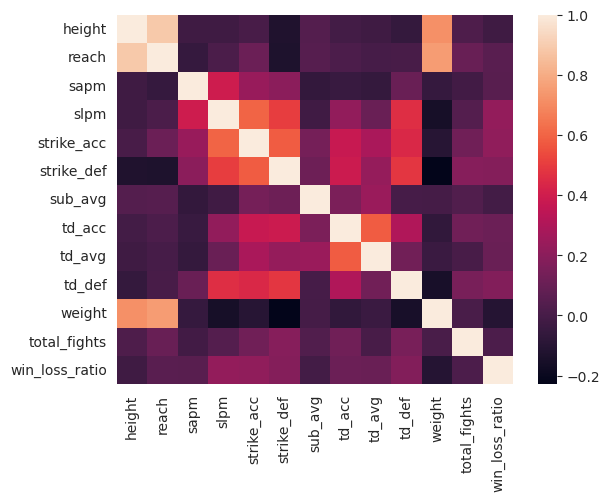

In [130]:
# columns = ['date_of_birth', 'fighter_name', 'fighter_record', 'height', 'reach',
#        'sapm', 'slpm', 'stance', 'strike_acc', 'strike_def', 'sub_avg',
#        'td_acc', 'td_avg', 'td_def', 'weight', 'dob', 'no_contest', 'win',
#        'loss', 'draw', 'total_fights', 'win_loss_ratio']
correlation_columns = ['height', 'reach', 'sapm', 'slpm',
                       'stance', 'strike_acc', 'strike_def',
                       'sub_avg', 'td_acc', 'td_avg', 'td_def',
                       'weight', 'total_fights', 'win_loss_ratio']

# sns.pairplot(fdf[correlation_columns])
corcolsdf = fdf[correlation_columns]
sns.heatmap(corcolsdf.corr())
plt.show()

In [131]:
# Create correlation matrix
corr_matrix = corcolsdf.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper

/tmp/ipykernel_6832/759920943.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = corcolsdf.corr().abs()
/tmp/ipykernel_6832/759920943.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


,height,reach,sapm,slpm,strike_acc,strike_def,sub_avg,td_acc,td_avg,td_def,weight,total_fights,win_loss_ratio
height,NaN,0.886682,0.027138,0.025259,0.004519,0.125197,0.039699,0.010624,0.026869,0.059380,0.721169,0.021868,0.027626
reach,NaN,NaN,0.052039,0.014016,0.107904,0.131577,0.045546,0.019998,0.000573,0.003517,0.754674,0.099370,0.054128
sapm,NaN,NaN,NaN,0.392108,0.236662,0.199030,0.062118,0.043800,0.059399,0.106378,0.053038,0.017440,0.053579
slpm,NaN,NaN,NaN,NaN,0.600601,0.505000,0.022191,0.220770,0.104112,0.458769,0.156257,0.042644,0.224649
strike_acc,NaN,NaN,NaN,NaN,NaN,0.578807,0.136801,0.373107,0.288292,0.440427,0.101190,0.124966,0.212484
strike_def,NaN,NaN,NaN,NaN,NaN,NaN,0.113119,0.389962,0.229227,0.484644,0.229328,0.187869,0.180276
sub_avg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.156489,0.242085,0.000057,0.003938,0.034072,0.010769
td_acc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.579144,0.306304,0.066949,0.122049,0.106910
td_avg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.129186,0.039534,0.004685,0.103323
td_def,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.151105,0.147189,0.177446


In [132]:
# Correlated pairs
# (height, reach) .8
# (strike_acc, slpm) .6
# (strike_def, slpm) .5
# (strike_acc, strike_def) .57
# (td_acc, td_avg) .58
# (weight, height) .72
# (weight, reach) .75

In [156]:
# USE TEMP PAST THIS POINT!

import sklearn
from sklearn.model_selection import train_test_split

columns = ['height', 'sapm', 'slpm', 'strike_acc', 'strike_def', 'sub_avg',
           'td_acc', 'td_avg', 'td_def', 'weight', 'no_contest', 'win',
           'loss', 'draw', 'total_fights', 'win_loss_ratio', 'reach']

# DROP NA!
temp = fdf[columns].dropna()

In [158]:
temp = sklearn.utils.shuffle(temp)
columns = ['height', 'sapm', 'slpm', 'strike_acc', 'strike_def', 'sub_avg',
           'td_acc', 'td_avg', 'td_def', 'weight', 'total_fights', 'win_loss_ratio']
X, y = temp[columns], temp["reach"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [191]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [192]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

f = linear_model.LinearRegression()
f.fit(X_train, y_train)
reach_predictions = f.predict(X_test)
mse = mean_squared_error(y_test, reach_predictions)
r2 = mean_squared_error(y_test, reach_predictions)

In [182]:
print(f"MSE: {mse}")
print(f"r2: {r2}")

MSE: 3.3511988823955026
r2: 3.3511988823955026


After imputing the values using regression, we plot height vs reach. So far, this function

looks like a reasonable approximator

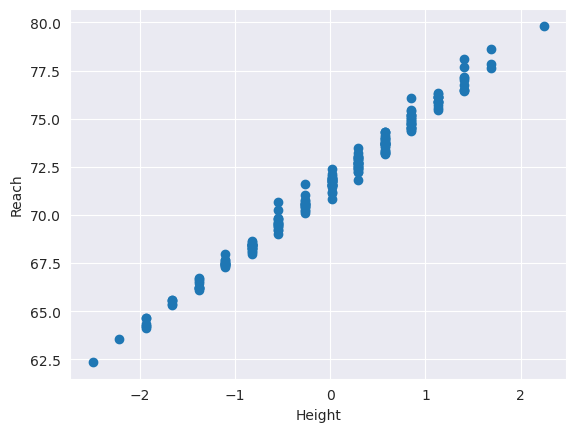

In [203]:
plt.scatter(X_test[:, 0], reach_predictions)
plt.xlabel("Height")
plt.ylabel("Reach")
plt.show()
# val = np.concatenate((X_test, reach_predictions), axis=1)
# val

In [19]:
# import utils
# path = project_root / "predictor"
# xtrain, ytrain, xtest, ytest = utils.get_train_test_data(path, "Fight_Stats")


Processed_Data/FightStats/data.npz is the processed data from fighters_bouts_joined table

This data gets fed to FightStatsModel

In [9]:
print("yes")

yes


Processor class save_train..() method called at end of main creates

..Fight_Winner/Data/Processed_Data/data.npz. The df before save has 52 columns

Resulting df has the 8 target variables

In [74]:
base_dir = project_root / "predictor"
proc = processor.Processor(fbdf, base_dir)
# proc = Processor(fbjdf, base_dir)
# proc.read()
# proc.drop_unused_columns()
# proc.shuffle_winner_positions()
# proc.process_categorical_columns()
# proc.set_target()
# proc.impute()
# proc.scale()
# proc.stratify_shuffle()
# self.save_train_test_to_file('Fight_Winner')
proc.main()

event_attendence not dropped as it is not in dataframe


KeyboardInterrupt: 

In [11]:
len(proc.fight_bouts_bak.columns)

52

In [12]:
# /home/justin/pycharmprojects/fight_predictor/predictor/Notebooks/Data/Scraped_Data/fighters_bouts_joined.csv'

Processor class save_train..() method called at end of main creates

..Fight_Stats/Data/Processed_Data/data.npz. The df before save has 52 columns

Resulting df does NOT the 8 target variables

In [13]:
sp = processor.StatsProcessor(fbdf, base_dir)
# sp.read()
# sp.drop_unused_columns()
# sp.set_targets()
# sp.drop_targets_from_df()
# sp.shuffle_winner_positions()
# sp.process_categorical_columns()
# sp.fight_bouts.drop(columns='winner', inplace=True)
# sp.impute()
# sp.scale()
# sp.split_data()
# self.save_train_test_to_file('Fight_Stats', self.fight_stats_targets)
sp.main()

event_attendence not dropped as it is not in dataframe
saving at /home/justin/pycharmprojects/fight_predictor/predictor/Data/Processed_Data/Fight_Stats


In [14]:
len(sp.fight_bouts_bak.columns)

44

In [ ]:
import models

fsm = models.FightStatsModel()

2023-02-05 20:23:58.533913: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-05 20:23:58.650160: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-05 20:23:58.650176: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-05 20:23:59.788828: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [ ]:
wm = models.WinnerModel()